# **Asthma Exacerbation Prediction from Wearable Heart Rate**

**TL;DR —** Built a temporal machine learning pipeline to forecast near-term asthma exacerbations using both **passive smartwatch heart rate** and **active questionnaire** data.  
Structured framework: **7-day lookback → 2-day buffer → 3-day horizon**.  
Models: **Logistic Regression baseline** and **XGBoost (interpreted with SHAP)**.  
**Headline results (test set):** Active model AUROC = 0.84 / AUPRC = 0.65; Passive HR model AUROC = 0.76 / AUPRC = 0.49.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cianmcguinn/asthma-exacerbation-wearables/blob/main/notebooks/project.ipynb)
[![nbviewer](https://img.shields.io/badge/view-nbviewer-blue)](https://nbviewer.org/github/cianmcguinn/asthma-exacerbation-wearables/blob/main/notebooks/project.ipynb)
[Back to repository](https://github.com/cianmcguinn/asthma-exacerbation-wearables)

**Jump to:**  
[Problem](#problem) • [Reproducibility](#reproducibility) • [Data and Cohort](#data-and-cohort) • [Leakage Control and Splits](#leakage-control-and-splits) • [Feature Engineering](#Feature-Engineering) • [Models and Tuning](#models-and-tuning) • [Results](#results) • [Interpretability](#interpretability) • [Sensitivity Analyses](#sensitivity-analyses) • [Limitations](#limitations)

<p class="muted">This page is an HTML summary exported from the project notebook for easier viewing of results and figures.</p>


In [ ]:
# --- Drive + repo path -------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import sys

REPO = Path("/content/drive/MyDrive/Colab Notebooks/Dissertation")
if str(REPO) not in sys.path:
    sys.path.insert(0, str(REPO))


(REPO / "src" / "__init__.py").touch(exist_ok=True)

SAVE_DIR = REPO
SAVE_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
try:
    %load_ext autoreload
    %autoreload 2
    import IPython, sys as _sys
    print(f"Autoreload ON (IPython {IPython.__version__}, Python {_sys.version.split()[0]})")
except Exception as e:
    print("Autoreload unavailable:", e)

## **<span id="problem"></span>Problem**

Asthma affects **260 million people** worldwide and causes around **455 000 deaths each year**.  
Most care remains **reactive** — treatment starts *after* symptoms worsen.  
These acute flare-ups (exacerbations) drive most hospital admissions and NHS costs.

---

### **Why prediction is difficult**
Current early-warning systems rely on:
- **Symptom diaries** → subjective and often incomplete  
- **Electronic health records** → sparse, irregular, and not real-time  

Both approaches miss subtle, day-to-day physiological changes that occur *before* an attack.

---

### **Why wearables might help**
Smartwatches collect continuous, objective data with no patient effort.  
Among these signals, **heart rate (HR)** may reflect early loss of asthma control — yet its **stand-alone predictive power** is unknown.

---

### **This project**
This study builds a **temporal machine-learning pipeline** to forecast asthma exacerbations using:
- **Passive smartwatch HR** (physiology)
- **Active questionnaire data** (symptoms & medication use)

The aim is to test how well HR alone can predict risk and whether it could support **scalable, low-burden asthma monitoring** in real-world care.



## **<span id="reproducibility"></span>Reproducibility**

All results are fully reproducible from the same notebook using fixed random seeds and consistent parameters.  
The code defines a single configuration for the **lookback**, **buffer**, and **horizon**, applies the same data splits, and regenerates all figures and tables automatically.

> 💡 This HTML is a code-free summary.  
> To view or rerun the analysis, open the linked Colab notebook above.



In [3]:
from dataclasses import dataclass
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import ParameterSampler
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew
import xgboost as xgb


RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

import warnings
# warnings.filterwarnings(
#     "ignore",
#     message=r".*Precision loss occurred in moment calculation.*",
#     category=RuntimeWarning
# )

warnings.filterwarnings("ignore")

@dataclass
class Config:

    # Paths
    PATH_HR_LIST: list[str] | None = None
    PATH_INHALER: str = "<SET>"
    PATH_QUESTIONNAIRE: str = "<SET>"

    # Splits
    TRAIN_RATIO: float = 0.60
    VAL_RATIO: float = 0.15
    MIN_USER_WINDOWS_TRAIN_ONLY: int = 20

    # Temporal design
    LOOKBACK: int = 7
    BUFFER: int = 2
    HORIZON: int = 3

    # Imbalance & scaling
    IMBALANCE: str | None = None          # None|'ros'|'rus'|'smote'
    SCALING: str | None = None            # None|'per_user_minmax'

    # Outcome
    OUTCOME_DEF: str = 'primary'          # 'primary'|'consecutive'
    OUTCOME_SOURCE: str = 'inhaler'       # 'inhaler'|'questionnaire'

    # Label completeness (related to outcome definition)
    MIN_OBS_IN_HORIZON: int = 2
    ALLOW_PARTIAL_HORIZON: bool = True

    # HR Days Sensitivity
    MIN_HR_DAYS_PER_USER: int | None = None
    HR_EXPECTED_SAMPLES_PER_DAY: int = 1440

    # Feature selection (passive)
    VAR_NEAR_ZERO_THR: float = 1e-8
    CORR_RHO_MAX: float = 0.95

    # Passive preprocessing
    FFILL_LIMIT_DAYS: int = 3
    DROP_ANCHORS_FOR_LOW_HR: bool = False
    HR_MIN_COVERAGE: float = 0.50

    # Active preprocessing
    DQ_IMPUTE_METHOD: str = "ffill"
    DQ_FFILL_LIMIT_DAYS: int = 3
    INCLUDE_RELIEVER_PREV1: bool = True
    ACTIVE_FS_MODE: str = 'var_corr'      # 'none'|'var'|'var_corr'

    # Tuning & early stopping
    XGB_N_SAMPLES: int = 100
    LR_N_SAMPLES: int = 100
    XGB_EARLY_STOP_ROUNDS: int = 20
    XGB_MAX_BOOST_ROUNDS: int = 2000


    # Threshold policy
    THRESHOLD_POLICY: str = "f1"          # 'f1'|'target_recall'|'target_precision'
    THRESHOLD_TARGET: float | None = 0.50


CFG = Config()

CFG.SEED = RNG_SEED

# Paths (set once)
CFG.PATH_HR_LIST = [
    '/content/drive/MyDrive/Dissertation/anonym_aamos00_smartwatch1.csv',
    '/content/drive/MyDrive/Dissertation/anonym_aamos00_smartwatch2.csv',
    '/content/drive/MyDrive/Dissertation/anonym_aamos00_smartwatch3.csv',
]
CFG.PATH_INHALER = '/content/drive/MyDrive/Dissertation/anonym_aamos00_smartinhaler.csv'
CFG.PATH_QUESTIONNAIRE = '/content/drive/MyDrive/Dissertation/anonym_aamos00_dailyquestionnaire.csv'



In [4]:
from src.config import set_global_seed, render_side_by_side, env_report_df, write_min_requirements

set_global_seed(RNG_SEED)
render_side_by_side(CFG, seed=RNG_SEED)

# optional: export a tiny requirements.txt for reproducibility
df_pkgs = env_report_df()
if write_min_requirements:  # stays safe if not available
    _ = write_min_requirements(df_pkgs, "/content/requirements.txt")


Setting,Value
Seed,42
Lookback / Buffer / Horizon (days),7 / 2 / 3
Outcome source,inhaler
Outcome definition,primary
Threshold policy,f1 (target=0.5)
Imbalance method,None
Scaling,None
HR min coverage (fraction of valid minutes/day),0.5
"FFILL limit (passive, days)",3
Package,Version


## **<span id="data-and-cohort"></span>Data & Cohort**

This project used the **AAMOS-00** dataset — a UK study of **22 adults with severe asthma** monitored for up to six months.  
Each participant contributed data from three digital sources:

| Stream | Data type | Description | Median coverage |
|:--|:--|:--|:--|
| **Smartwatch** | Heart rate, steps, activity | Continuous minute-level physiology | ~57% of study days |
| **Smart inhaler** | Actuation events | Objective reliever-use logs | ~23% of study days |
| **Questionnaires** | Symptoms, medication, triggers | Daily self-reports | ~60% of study days |

**Outcome:** days with elevated reliever use (relative to each participant’s baseline).  
**Predictors:** passive HR features (variability, circadian averages) and active questionnaire items (symptoms, reliever use, triggers).

---

In [ ]:
!pip install python-docx

In [6]:
from IPython.display import HTML, display

import os

from src.data_io import load_raw
from src.reporting import build_union_span, presence_days, summarise_stream, export_table_to_docx


raw = load_raw(CFG.PATH_HR_LIST, CFG.PATH_INHALER, CFG.PATH_QUESTIONNAIRE)


hr_raw, inh_raw, dq_raw = raw["hr"], raw["inhaler"], raw["dq"]
span_all       = build_union_span(hr_raw, inh_raw, dq_raw)
watch_presence = presence_days(hr_raw)
inh_presence   = presence_days(inh_raw)
dq_presence    = presence_days(dq_raw)

table2_improved = pd.DataFrame([
    summarise_stream("Smartwatch (HR, steps, activity)", watch_presence, span_all),
    summarise_stream("Inhaler use",                       inh_presence,  span_all),
    summarise_stream("Questionnaire",                     dq_presence,   span_all),
])
# …then your chips/cards + styled table HTML exactly as you have now …

# ---------- clean HTML: chips + cards + styled table ----------
css = """
<style>
  .ds-sources { display:flex; gap:16px; flex-wrap:wrap; margin:8px 0 14px; }
  .ds-chip    { border:1px solid #e5e7eb; border-radius:9999px; padding:4px 10px; font-size:12.5px; background:#fafafa; }
  .cards      { display:flex; gap:12px; flex-wrap:wrap; margin:8px 0 10px; }
  .card       { border:1px solid #e5e7eb; border-radius:10px; padding:10px 12px; min-width:220px; background:#fff; }
  .card h4    { margin:0 0 6px 0; font-size:14px; }
  .card .big  { font-size:20px; font-weight:600; }
  .tbl        { border-collapse:collapse; width:100%; }
  .tbl th, .tbl td { border:1px solid #e5e7eb; padding:6px 8px; }
  .tbl caption { caption-side: top; text-align:left; font-weight:600; padding:4px 0 8px; }
</style>
"""

chips = f"""
<div class="ds-sources">
  <div class="ds-chip">HR: {hr_raw.shape[0]:,} rows • {hr_raw.shape[1]} cols</div>
  <div class="ds-chip">Inhaler: {inh_raw.shape[0]:,} rows • {inh_raw.shape[1]} cols</div>
  <div class="ds-chip">Questionnaire: {dq_raw.shape[0]:,} rows • {dq_raw.shape[1]} cols</div>
</div>
"""

cards = []
for _, r in table2_improved.iterrows():
    cards.append(
        f"""<div class="card">
              <h4>{r['stream']}</h4>
              <div class="big">{int(r['participants'])} participants</div>
              <div>{int(r['total_days']):,} total days • {r['mean_%_completeness']}% complete</div>
            </div>"""
    )
cards_html = f'<div class="cards">{"".join(cards)}</div>'

styled_tbl = (
    table2_improved.rename(columns={"mean_%_completeness":"mean % completeness"})
    .style.format({"mean % completeness": "{:.1f}"})
    .hide(axis="index")
    .set_caption("Table 2 — Dataset summary (before pre-processing)")
    .set_table_attributes('class="tbl"')
).to_html()

display(HTML(css + chips + cards_html + styled_tbl))

# Save artifacts quietly
_ = export_table_to_docx(table2_improved, os.path.join(SAVE_DIR, "Table2_DatasetSummary.docx"),
                         "Table 2. Dataset Summary")
table2_improved.to_csv(os.path.join(SAVE_DIR, "Table2_DatasetSummary.csv"), index=False)


stream,participants,total_days,median_days,IQR_low,IQR_high,min_days,max_days,mean % completeness
"Smartwatch (HR, steps, activity)",20,1567,58,7,131,0,179,57.3
Inhaler use,17,694,10,1,30,0,183,22.8
Questionnaire,22,1583,52,19,126,2,173,59.9


### **Pre-processing**

Data were cleaned, harmonised, and aligned to a **dense daily calendar** per user:
- Implausible HR values clipped (<30 or >220 bpm)  
- Daily HR summaries derived (mean, min, max, variability, circadian bins)  
- Questionnaire items harmonised and forward-filled for short gaps (≤3 days)  
- Inhaler data collapsed to daily counts  
- Participants with fewer than two reliever uses excluded

All streams were merged into consistent **per-person, per-day records**, ready for temporal windowing.

---

<details>
  <summary>View helper functions (optional)</summary>

| Helper | Purpose (one-line) | Inputs | Key outputs |
|---|---|---|---|
| `clean_passive_hr` | Clean and summarise HR minute-level data. | HR CSVs | `hr_min` |
| `make_user_calendar` | Build dense daily timeline per user. | Inhaler events | `calendar` |
| `filter_inhaler_users_with_min_uses` | Retain users with ≥2 reliever uses. | Inhaler events | Filtered inhaler |
| `clean_active_questionnaire` | Harmonise names/dtypes; derive medication fields. | Questionnaire CSV | Cleaned daily data |
| `align_active_to_calendar` | Align questionnaire to dense calendar; forward-fill short gaps. | Cleaned DQ, `calendar` | `ACTIVE_DAILY` |
</details>

In [7]:
from src.preprocess import (
    clean_passive_hr, make_user_calendar, filter_inhaler_users_with_min_uses
)
from src.viz import chips, cards, styled_table, show_table

# Clean + calendar
hr_min, hr_stats = clean_passive_hr(raw["hr"], with_stats=True)
inh_daily = make_user_calendar(raw["inhaler"], "user_key", "date", source="inhaler")

# Keep users with ≥ 2 uses
users_keep = filter_inhaler_users_with_min_uses(raw["inhaler"], user_col="user_key", min_uses=2)
hr_min    = hr_min[hr_min["user_key"].isin(users_keep)].reset_index(drop=True)
inh_daily = inh_daily[inh_daily["user_key"].isin(users_keep)].reset_index(drop=True)

# Chips (quick context)
chips(
    f"`hr_min` {hr_min.shape[0]:,} × {hr_min.shape[1]}",
    f"`inh_daily` {inh_daily.shape[0]:,} × {inh_daily.shape[1]}",
)

# Mini cards (summary)
cards([
    {"title": "Passive (wearables)", "big": f"{len(set(users_keep))} participants",
     "sub": f"HR implausible flagged: {hr_stats['hr_flagged_implausible']:,} "
            f" • HR NaNs after: {hr_stats['hr_nan_after']:,}"},
])


In [8]:
from IPython.display import HTML, display
from src.preprocess import clean_active_questionnaire, align_active_to_calendar
from src.viz import chips, cards, styled_table, show_table

# Pass the policy explicitly (same behavior as before)
dq_clean = clean_active_questionnaire(
    raw["dq"],
    include_prev1=CFG.INCLUDE_RELIEVER_PREV1
)

cal = inh_daily[["user_key", "date"]].drop_duplicates()

dq_aligned, impute_stats = align_active_to_calendar(
    dq_clean, cal,
    method=CFG.DQ_IMPUTE_METHOD,
    limit_days=CFG.DQ_FFILL_LIMIT_DAYS,
    with_stats=True
)

# Add observed-day flag (for completeness metrics later)
obs = dq_clean[["user_key", "date"]].drop_duplicates().assign(obs_day=1)
ACTIVE_DAILY = dq_aligned.merge(obs, on=["user_key", "date"], how="left")
ACTIVE_DAILY["obs_day"] = ACTIVE_DAILY["obs_day"].fillna(0).astype("Int8")

# ----- Minimal caption (self-contained explanation) --------------------
method = impute_stats.get("impute_method", "").upper()
limit  = impute_stats.get("ffill_limit_days", None)

if method == "FFILL" and limit is not None:
    cap = f"Questionnaire rows aligned to the inhaler calendar; missing feature days imputed by forward-fill up to {limit} days."
elif method == "ZERO":
    cap = "Questionnaire rows aligned to the inhaler calendar; missing feature days imputed with zeros."
else:
    cap = f"Questionnaire rows aligned to the inhaler calendar; imputation policy: {method or 'n/a'}."

display(HTML(f'<div style="margin:6px 0 6px; font-size:13px; color:#555;">{cap}</div>'))

# ----- Compact chips (shape + observed/imputed/coverage) ---------------
observed_days_raw = obs.shape[0]                            # raw questionnaire unique (user,date)
imputed_days      = impute_stats.get("missing_days_before", 0)
aligned_rows      = dq_aligned.shape[0]

# Coverage of the aligned grid that was actually observed (not imputed)
coverage_pct = (100.0 * (aligned_rows - imputed_days) / aligned_rows) if aligned_rows else 0.0

chips([
    f"`ACTIVE_DAILY` {ACTIVE_DAILY.shape[0]:,} × {ACTIVE_DAILY.shape[1]}",
    f"observed days (raw): {observed_days_raw:,}",
    f"imputed days: {imputed_days:,}",
    f"post-align coverage: {coverage_pct:.1f}%",
])


# ----- Card (policy + succinct stat) -----------------------------------
sub_text = f"missing days before: {imputed_days:,}"
if method == "FFILL" and limit is not None:
    sub_text += f" (limit {limit}d)"

cards([{
    "title": "Active alignment",
    "big": method,
    "sub": sub_text,
}])




## **<span id="leakage-control-and-splits"></span>Leakage Control & Splits**

All data were split **within each user** and in **chronological order** to prevent information leakage between training, validation, and test sets.  
This ensures that lookback, buffer, and horizon windows never cross split boundaries.

---

### **Chronological per-user splits**
- The function `split_timelines()` walks each user’s daily calendar and assigns windows to **train**, **validation**, and **test** sets using fixed ratios (`CFG.TRAIN_RATIO`, `CFG.VAL_RATIO`).
- Users with too few windows (`< CFG.MIN_USER_WINDOWS_TRAIN_ONLY`) are placed in **train-only**.
- The resulting masks are **disjoint** and **exhaustive**, covering 100% of available days.



In [9]:
from src.splits import split_timelines, make_split_masks, per_user_split_summary
from src.viz import show_table


# 1) Build the daily calendar from inhaler (chronological per-user)
calendar = (
    inh_daily[["user_key", "date", "use"]]
    .sort_values(["user_key", "date"])
    .reset_index(drop=True)
)

# 2) Chronological per-user splits (use CFG values)
split = split_timelines(
    calendar, "user_key", "date",
    train_ratio=CFG.TRAIN_RATIO,
    val_ratio=CFG.VAL_RATIO,
    min_user_windows_train_only=CFG.MIN_USER_WINDOWS_TRAIN_ONLY
)
masks = make_split_masks(len(calendar), split)

# 3) Assert disjoint + complete
counts = masks["train"].astype(int) + masks["val"].astype(int) + masks["test"].astype(int)
assert (counts == 1).all(), "Split masks must be disjoint and cover all rows."

# 4) Compact per-user summary (first 5 users)
summary = per_user_split_summary(calendar, masks).head(5)
show_table(summary, "Per-user day counts by split (first 5 users)")

SPLIT = split
MASKS = masks
CALENDAR_SORTED = calendar


test,train,val
45,106,27
0,19,0
28,67,17
48,114,28
16,37,10


### **Anchor generation (L–B–H framing)**
To maintain temporal integrity, anchor indices were built per user with the following window structure:

| Segment | Definition |
|:--|:--|
| **Lookback (L)** | `t−L … t−1` |
| **Buffer (B)** | `t … t+B−1` |
| **Horizon (H)** | `t+B … t+B+H−1` |

Each anchor is computed **within its assigned split**, ensuring no overlap across train/val/test.



In [10]:
from src.temporal import build_all_anchors, validate_anchors
from src.viz import show_table
import pandas as pd

anchors = build_all_anchors(
    CALENDAR_SORTED, MASKS,
    lookback=CFG.LOOKBACK, buffer=CFG.BUFFER, horizon=CFG.HORIZON
)

# Normalise column name once (downstream expects 'anchor_row_idx')
for k in ("train", "val", "test"):
    if "anchor_idx" in anchors[k].columns and "anchor_row_idx" not in anchors[k].columns:
        anchors[k] = anchors[k].rename(columns={"anchor_idx": "anchor_row_idx"})

# Validate indices live within their split’s mask
validate_anchors(anchors, MASKS)

# Small counts table (nicer than print lines)
counts = pd.DataFrame({"n_anchors": {k: len(v) for k, v in anchors.items()}})
show_table(counts, "Anchor counts by split")

# Optional: tiny preview (first 3 rows each) for readers
preview = []
for k, df in anchors.items():
    if not df.empty:
        cols = [c for c in ["user_key","t_date","lb_start_idx","lb_end_idx",
                            "buf_start_idx","buf_end_idx","hz_start_idx","hz_end_idx"]
                if c in df.columns]
        tmp = df[cols].head(3).copy()
        tmp.insert(0, "split", k)
        preview.append(tmp)
if preview:
    show_table(pd.concat(preview, ignore_index=True), "Example anchors (first 3 per split)")

ANCHORS = anchors


n_anchors
778
99
248


split,user_key,t_date,lb_start_idx,lb_end_idx,buf_start_idx,buf_end_idx,hz_start_idx,hz_end_idx
train,113,7,0,6,7,8,9,11
train,113,8,1,7,8,9,10,12
train,113,9,2,8,9,10,11,13
val,113,113,106,112,113,114,115,117
val,113,114,107,113,114,115,116,118
val,113,115,108,114,115,116,117,119
test,113,140,133,139,140,141,142,144
test,113,141,134,140,141,142,143,145
test,113,142,135,141,142,143,144,146


With anchors defined, **features are aggregated over the lookback**, enforced by the **buffer**, and labelled in the **horizon**, creating fully leakage-safe training data.

---

### **HR coverage - sensitivity test**
A sensitivity filter was applied to include only users with adequate HR completeness:
- A day is valid if ≥ `CFG.HR_MIN_COVERAGE` of minute-level HR readings are present.  
- Users must have at least `CFG.MIN_HR_DAYS_PER_USER` valid HR days to be retained.  
- This same subset is used consistently across all splits.







In [11]:
if CFG.MIN_HR_DAYS_PER_USER is not None:
    samples_per_day = CFG.HR_EXPECTED_SAMPLES_PER_DAY
    cov = (
        hr_min[["user_key", "date", "hr"]]
        .assign(is_valid=hr_min["hr"].notna())
        .groupby(["user_key", "date"])["is_valid"].sum()
        .div(samples_per_day)
        .reset_index(name="hr_cov")
    )
    valid_days = cov.loc[cov["hr_cov"] >= CFG.HR_MIN_COVERAGE, ["user_key", "date"]]
    days_per_user = valid_days.groupby("user_key")["date"].nunique()
    keep_users = set(days_per_user[days_per_user >= CFG.MIN_HR_DAYS_PER_USER].index.astype(str))

    users_arr = CALENDAR_SORTED["user_key"].astype(str).values
    for s in ("train", "val", "test"):
        MASKS[s] = MASKS[s] & np.isin(users_arr, list(keep_users))

    print(f"HR-days filter ≥{CFG.MIN_HR_DAYS_PER_USER}: kept {len(keep_users)} users")



## **<span id="Feature Engineering"></span>Feature Engineering**

This section transforms raw wearable and questionnaire data into **model-ready feature matrices**.  
Steps include daily signal derivation, 7-day temporal rollups, outcome labelling, and feature selection.

---

### **Daily feature derivation**

**Passive (smartwatch)** — From minute-level HR, steps, and activity logs:  
- Derived HR metrics (mean, min, max, SDNN, RMSSD, abrupt-change flags)  
- Circadian averages (night, morning, afternoon, evening)  
- Activity fractions (active, sedentary, sleep) and total steps  
- Valid-data ratio (**HR coverage**)  
Gaps were forward-filled up to `CFG.FFILL_LIMIT_DAYS`.

**Active (questionnaire)** — From daily self-reports:  
- Night/day symptoms, activity limitation, preventer use, reliever use, and triggers  
- Derived medication adherence (`preventer_delta`) and previous-day reliever use (`reliever_prev1`)  
- Aligned to the dense per-user calendar with constrained forward-fill (≤3 days)


In [12]:
from src.features import daily_passive_features, align_passive_to_calendar_and_ffill, rollup_7d_passive
from src.viz import chips

passive_daily_raw = daily_passive_features(
    hr_min,
    samples_per_day=CFG.HR_EXPECTED_SAMPLES_PER_DAY,
    hr_min_coverage=CFG.HR_MIN_COVERAGE,
)
passive_daily = align_passive_to_calendar_and_ffill(
    passive_daily_raw, CALENDAR_SORTED, limit_days=CFG.FFILL_LIMIT_DAYS
)

X_passive = {s: rollup_7d_passive(passive_daily, ANCHORS[s], "user_key","date", lookback=CFG.LOOKBACK)
             for s in ("train","val","test")}
for s, xf in X_passive.items():
    n_feat = sum(c not in ("user_key","date") for c in xf.columns)
    chips(f"passive {s}: rows={len(xf)} • features={n_feat}")


In [13]:
from src.features import daily_active_features, rollup_7d_active

active_daily = daily_active_features(ACTIVE_DAILY, include_prev1=CFG.INCLUDE_RELIEVER_PREV1)
X_active = {s: rollup_7d_active(active_daily, ANCHORS[s], "user_key","date", lookback=CFG.LOOKBACK)
            for s in ("train","val","test")}
for s, xf in X_active.items():
    n_feat = sum(c not in ("user_key","date") for c in xf.columns)
    chips(f"active {s}: rows={len(xf)} • features={n_feat}")


### **7-day temporal rollups**

For each anchor day *t*, features were aggregated across the **7-day lookback** window:  
`mean`, `median`, `max`, `min`, `range`, `std`, `skew`, `slope`, and `last`.  
Active features required ≥50% observed days within the window.  

**Outputs:**
- Passive matrices: 778 / 99 / 248 rows with 135 features each (train/val/test)  
- Active matrices: 576 / 67 / 137 rows with 63 features each

---

### **Daily variables and descriptives**


In [14]:
from src.viz import styled_table
from src.reporting import export_table_to_docx, union_span_from_daily, coverage_for_columns  # you already have this helper

span_all = union_span_from_daily([passive_daily, active_daily])

pd_cols = list(passive_daily.columns)
groups_passive = [
    ("HR (central tendency)", [c for c in pd_cols if c in ["mean_hr","median_hr","min_hr","max_hr"]], "numeric","bpm","Daily HR summary"),
    ("HR (variability)",      [c for c in pd_cols if c in ["std_hr","rmssd_hr","abrupt_hr_changes"]], "numeric","bpm / count","HR variation & abrupt changes"),
    ("Circadian HR (4 bins)", [c for c in pd_cols if (c.startswith("hr_") and c.endswith("_mean") and c not in ["mean_hr","median_hr"])], "numeric","bpm","Night/Morning/Afternoon/Evening"),
    ("Activity fractions",    [c for c in pd_cols if c.startswith("frac_")], "proportion","0–1","Sleep/Sedentary/Active/Unknown"),
    ("Steps total",           [c for c in pd_cols if c == "steps_total"], "numeric","steps/day","Daily steps"),
    ("HR coverage",           [c for c in pd_cols if c == "hr_coverage"], "proportion","0–1","Valid HR minutes in day"),
]

ad_cols = list(active_daily.columns)
groups_active = [
    ("Night-time symptoms",      ["daily_night_symp"] if "daily_night_symp" in ad_cols else [], "binary","0/1","Self-report"),
    ("Day-time symptoms",        ["daily_day_symp"]   if "daily_day_symp"   in ad_cols else [], "binary","0/1","Self-report"),
    ("Activity limitation",      ["daily_limit_activity"] if "daily_limit_activity" in ad_cols else [], "binary","0/1","Self-report"),
    ("Preventer taken",          ["preventer_taken"]  if "preventer_taken"  in ad_cols else [], "binary","0/1","Self-report"),
    ("Preventer delta",          ["preventer_delta"]  if "preventer_delta"  in ad_cols else [], "ordinal","−1/0/+1","Less/usual/more"),
    ("Trigger exposures",        ["daily_triggers"]   if "daily_triggers"   in ad_cols else [], "count","events/day","Self-report"),
]
if "reliever_prev1" in ad_cols:
    groups_active.append(("Reliever use (prev day)", ["reliever_prev1"], "count","puffs/day","Lag-1"))

rows = []
for disp, cols, typ, unit, desc in groups_passive:
    cov = coverage_for_columns(passive_daily, cols, span_all)
    rows.append({"Model":"Passive","Daily variable":disp,"Columns":", ".join(cols) if cols else "-",
                 "Type":typ,"Unit/scale":unit,"Description":desc,"coverage_%":None if np.isnan(cov) else round(cov,1)})

for disp, cols, typ, unit, desc in groups_active:
    cov = coverage_for_columns(active_daily, cols, span_all)
    rows.append({"Model":"Active","Daily variable":disp,"Columns":", ".join(cols) if cols else "-",
                 "Type":typ,"Unit/scale":unit,"Description":desc,"coverage_%":None if np.isnan(cov) else round(cov,1)})

table_daily_vars = pd.DataFrame(rows, columns=["Model","Daily variable","Columns","Type","Unit/scale","Description","coverage_%"])
styled_table(table_daily_vars, "Table X. Daily variables by model (pre-aggregation)")

docx_path = SAVE_DIR / "TableX_DailyVariables_preAggregation.docx"
csv_path  = SAVE_DIR / "TableX_DailyVariables_preAggregation.csv"
export_table_to_docx(table_daily_vars, str(docx_path), "Table X. Daily variables by model (pre-aggregation)")
table_daily_vars.to_csv(csv_path, index=False)




Model,Daily variable,Columns,Type,Unit/scale,Description,coverage_%
Passive,HR (central tendency),"mean_hr, min_hr, max_hr",numeric,bpm,Daily HR summary,69.500000
Passive,HR (variability),"std_hr, abrupt_hr_changes, rmssd_hr",numeric,bpm / count,HR variation & abrupt changes,69.500000
Passive,Circadian HR (4 bins),"hr_night_mean, hr_morning_mean, hr_afternoon_mean, hr_evening_mean",numeric,bpm,Night/Morning/Afternoon/Evening,69.500000
Passive,Activity fractions,"frac_active, frac_sedentary, frac_sleep, frac_unknown",proportion,0–1,Sleep/Sedentary/Active/Unknown,69.500000
Passive,Steps total,steps_total,numeric,steps/day,Daily steps,69.500000
Passive,HR coverage,hr_coverage,proportion,0–1,Valid HR minutes in day,74.300000
Active,Night-time symptoms,daily_night_symp,binary,0/1,Self-report,82.100000
Active,Day-time symptoms,daily_day_symp,binary,0/1,Self-report,82.100000
Active,Activity limitation,daily_limit_activity,binary,0/1,Self-report,82.100000
Active,Preventer taken,preventer_taken,binary,0/1,Self-report,82.100000


In [15]:
from src.reporting import summary_from_per_user

sw_rows = []
if "mean_hr" in passive_daily.columns:
    per_user_hr = passive_daily.groupby("user_key")["mean_hr"].median(numeric_only=True)
    sw_rows.append({"Domain":"Smartwatch","Variable":"Heart rate (daily mean)","Unit":"bpm", **summary_from_per_user(per_user_hr)})
if "steps_total" in passive_daily.columns:
    per_user_steps = passive_daily.groupby("user_key")["steps_total"].median(numeric_only=True)
    sw_rows.append({"Domain":"Smartwatch","Variable":"Steps per day","Unit":"steps/day", **summary_from_per_user(per_user_steps)})
sw_rows.append({"Domain":"Smartwatch","Variable":"Activity type (sleep/sedentary/active/unknown)","Unit":"-",
                "median":"", "IQR_low":"", "IQR_high":"", "min":"", "max":""})

dq_rows = []
dq_items = [
    ("Night-time symptoms (% of days)","daily_night_symp","binary"),
    ("Day-time symptoms (% of days)","daily_day_symp","binary"),
    ("Activity limitation (% of days)","daily_limit_activity","binary"),
    ("Trigger exposures (% of days ≥1)","daily_triggers","count_to_binary"),
    ("Preventer taken (% of days)","preventer_taken","binary"),
    ("Preventer delta (median)","preventer_delta","ordinal"),
]
if "reliever_prev1" in active_daily.columns:
    dq_items.append(("Reliever use (prev day, median)","reliever_prev1","count"))

dq_cols = ["user_key","date"] + [c for _, c, _ in dq_items if c in active_daily.columns]
dq = active_daily[dq_cols].copy()

if "obs_day" in active_daily.columns:
    obs = (active_daily[["user_key","date","obs_day"]]
           .assign(observed=(active_daily["obs_day"].fillna(0) > 0).astype(int))
           [["user_key","date","observed"]])
else:
    nonkey = [c for c in dq.columns if c not in ("user_key","date")]
    obs = (dq.assign(observed=lambda x: x[nonkey].notna().any(axis=1).astype(int))
             [["user_key","date","observed"]])
obs = obs.groupby(["user_key","date"], as_index=False)["observed"].max()

def percent_of_days(df, col, cond_fn):
    tmp = df[["user_key","date",col]].copy()
    tmp["_val"] = pd.to_numeric(tmp[col], errors="coerce")
    tmp["event"] = cond_fn(tmp["_val"])
    day = (tmp.groupby(["user_key","date"], as_index=False)["event"].max()
            .merge(obs, on=["user_key","date"], how="outer")
            .fillna({"observed":0, "event":0}))
    per_user = day.groupby("user_key").agg(event_days=("event","sum"),
                                           observed_days=("observed","sum"))
    per_user["pct_days"] = np.where(per_user["observed_days"]>0,
                                    100*per_user["event_days"]/per_user["observed_days"],
                                    np.nan).clip(0,100)
    return per_user["pct_days"]

for label, col, typ in dq_items:
    if col not in dq.columns: continue
    if typ == "binary":
        per_user_pct = percent_of_days(dq, col, lambda s: (pd.to_numeric(s, errors="coerce").fillna(0) > 0).astype(int))
        dq_rows.append({"Domain":"Questionnaire","Variable":label,"Unit":"% of observed days", **summary_from_per_user(per_user_pct)})
    elif typ == "count_to_binary":
        per_user_pct = percent_of_days(dq, col, lambda s: (pd.to_numeric(s, errors="coerce").fillna(0) >= 1).astype(int))
        dq_rows.append({"Domain":"Questionnaire","Variable":label,"Unit":"% of observed days", **summary_from_per_user(per_user_pct)})
    elif typ in ("ordinal","count"):
        per_user_med = dq.groupby("user_key")[col].median(numeric_only=True)
        unit = "1–5 (median across users)" if typ=="ordinal" else "puffs/day (median across users)"
        dq_rows.append({"Domain":"Questionnaire","Variable":label,"Unit":unit, **summary_from_per_user(per_user_med)})

table_daily_compact = pd.DataFrame(sw_rows + dq_rows,
                                   columns=["Domain","Variable","Unit","median","IQR_low","IQR_high","min","max"])
from src.viz import styled_table
styled_table(table_daily_compact, "Table Y. Compact daily-level descriptive statistics (cleaned)")

docx_path = SAVE_DIR / "TableY_CompactDailyDescriptives_Cleaned.docx"
csv_path  = SAVE_DIR / "TableY_CompactDailyDescriptives_Cleaned.csv"
export_table_to_docx(table_daily_compact, str(docx_path),
                     "Table Y. Compact daily-level descriptive statistics (cleaned)")
table_daily_compact.to_csv(csv_path, index=False)






Domain,Variable,Unit,median,IQR_low,IQR_high,min,max
Smartwatch,Heart rate (daily mean),bpm,85.901661,79.931393,87.730302,72.733101,90.968468
Smartwatch,Steps per day,steps/day,5956.750000,4029.375000,7814.250000,1078.500000,14951.000000
Smartwatch,Activity type (sleep/sedentary/active/unknown),-,,,,,
Questionnaire,Night-time symptoms (% of days),% of observed days,2.631579,0.000000,22.203224,0.000000,77.456647
Questionnaire,Day-time symptoms (% of days),% of observed days,100.000000,57.481540,100.000000,6.250000,100.000000
Questionnaire,Activity limitation (% of days),% of observed days,20.974547,0.000000,75.316456,0.000000,100.000000
Questionnaire,Trigger exposures (% of days ≥1),% of observed days,71.159863,43.279570,100.000000,0.000000,100.000000
Questionnaire,Preventer taken (% of days),% of observed days,100.000000,100.000000,100.000000,50.000000,100.000000
Questionnaire,Preventer delta (median),1–5 (median across users),0.000000,0.000000,0.000000,-1.000000,0.000000
Questionnaire,"Reliever use (prev day, median)",puffs/day (median across users),1.000000,0.000000,1.500000,0.000000,5.000000


### **Outcome definition**

Labels were generated per anchor using the same **lookback–buffer–horizon (L–B–H)** structure:
- **Primary:** 1 if ≥ 2 days in the horizon exceed the user’s baseline reliever use  
- **Alternative:** 1 if any two *consecutive* days exceed baseline  

Each user’s baseline was calculated from **train-only** days to avoid leakage.



In [16]:
from src.outcomes import select_usage_daily, compute_personal_baseline_by_train_keys, build_labels

USAGE_DAILY = select_usage_daily(CFG.OUTCOME_SOURCE, inh_daily, dq_aligned)

train_keys = CALENDAR_SORTED.loc[MASKS["train"], ["user_key","date"]].drop_duplicates()
baseline_by_user = compute_personal_baseline_by_train_keys(USAGE_DAILY, train_keys)

Y = {
    s: build_labels(
        usage_daily=USAGE_DAILY,
        anchors=ANCHORS[s],
        user_col="user_key",
        date_col="date",
        baseline_by_user=baseline_by_user,
        outcome_def=CFG.OUTCOME_DEF,
        buffer_days=CFG.BUFFER,
        horizon_days=CFG.HORIZON,
        min_obs_in_hz=CFG.MIN_OBS_IN_HORIZON,
        allow_partial=CFG.ALLOW_PARTIAL_HORIZON,
    )
    for s in ("train","val","test")
}
from src.viz import chips
for s in ("train","val","test"):
    n_lab, n_anc = len(Y[s]), len(ANCHORS[s])
    chips(f"{s}: labels={n_lab} / anchors={n_anc} ({(n_lab/n_anc if n_anc else 0):.1%})")
Y_LABELS = Y




### **Event trends**

Average HR rose in the days leading up to an exacerbation.  
The plot below shows mean ± 95 % CI HR deviation from baseline, centred at event onset (t = 0).


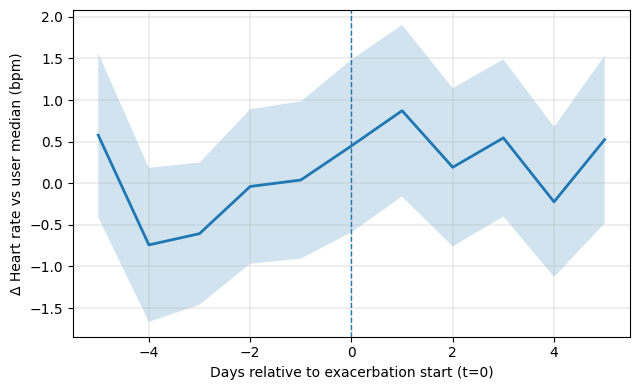

In [17]:
from src.viz import hr_trends_around_events
from IPython.display import Image, display
from pathlib import Path # Import Path

# Ensure SAVE_DIR is a Path object
SAVE_DIR = Path(SAVE_DIR)

summary, paths = hr_trends_around_events(
    passive_daily=passive_daily,
    usage_daily=USAGE_DAILY,
    baseline_by_user=baseline_by_user,
    save_dir=SAVE_DIR,   # this is a Path
)



### **Window and class balance summaries**



In [18]:
from src.features import assemble_matrices
from src.viz import chips, show_table
import pandas as pd


Xy_passive = {}
for s in ("train","val","test"):
    X, y, ids, feat_cols = assemble_matrices(X_passive[s], None, Y_LABELS[s], "passive", verbose=False)
    Xy_passive[s] = {"X":X,"y":y,"ids":ids,"feat_cols":feat_cols}

Xy_active = {}
for s in ("train","val","test"):
    X, y, ids, feat_cols = assemble_matrices(None, X_active[s], Y_LABELS[s], "active", verbose=False)
    Xy_active[s] = {"X":X,"y":y,"ids":ids,"feat_cols":feat_cols}

rows = []

for mode, pack in [("Passive", Xy_passive), ("Active", Xy_active)]:
    for split in ("train","val","test"):
        X = pack[split]["X"]; y = pack[split]["y"]
        rows.append({
            "model": mode, "split": split.capitalize(),
            "windows (n)": int(len(X)),
            "features (n)": int(X.shape[1]),
            "positives (n)": int(y.sum()),
            "% positive": round(100*y.mean(), 1) if len(y) else float("nan"),
        })

show_table(pd.DataFrame(rows), "Assembled matrices: size and class balance")



model,split,windows (n),features (n),positives (n),% positive
Passive,Train,778,135,217,27.900000
Passive,Val,99,135,17,17.200000
Passive,Test,248,135,32,12.900000
Active,Train,576,63,192,33.300000
Active,Val,67,63,13,19.400000
Active,Test,137,63,29,21.200000


In [19]:
import pandas as pd
from src.reporting import summarise_windows_dict, build_split_summary, ids_from_Xy
from src.viz import styled_table, chips


# ----- Passive (labelled windows) -----
per_user_passive, table4_passive = summarise_windows_dict(
    {"train": Y_LABELS["train"], "val": Y_LABELS["val"], "test": Y_LABELS["test"]},
    user_col="user_key", date_col="date"
)
table3a_passive = build_split_summary(Y_LABELS, user_col="user_key")

# ----- Active (modelled windows = features actually used) -----
obj_active = ids_from_Xy(Xy_active)
per_user_active, table4_active = summarise_windows_dict(
    obj_active, user_col="user_key", date_col="date"
)
table3a_active = build_split_summary(obj_active, user_col="user_key")

# ----- Combine with a 'model' flag so titles are crystal clear -----
table4_combined = (
    pd.concat(
        [
            table4_passive.assign(model="Passive"),
            table4_active.assign(model="Active"),
        ],
        ignore_index=True,
    )
    .rename(columns={"metric": "metric (per-user counts)"})
)

table3a_combined = pd.concat(
    [
        table3a_passive.assign(model="Passive"),
        table3a_active.assign(model="Active"),
    ],
    ignore_index=True,
)


# Optional one-line overview
chips(
    f"Passive windows: {int(table3a_combined.query('model==\"Passive\"')['windows (n)'].sum())}",
    f"Active windows: {int(table3a_combined.query('model==\"Active\"')['windows (n)'].sum())}",
)

# Consistent row order for Table 4
_metric_order = ["train_windows", "val_windows", "test_windows", "total_windows"]

# ---- Table 4: show one table per model (clean, compact) ----
for model, df in table4_combined.groupby("model", sort=False):
    t4 = (
        df.drop(columns="model")
          .rename(columns={"metric (per-user counts)": "metric"})
          .set_index("metric")
          .reindex(_metric_order)
          .reset_index()
    )
    styled_table(t4, f"Table 4 — {model}: participant & window summary")

    # Save per-model artifacts (optional)
    export_table_to_docx(
        t4,
        str(SAVE_DIR / f"Table4_{model}_ParticipantWindowSummary.docx"),
        f"Table 4 — {model}: participant & window summary",
    )
    t4.to_csv(SAVE_DIR / f"Table4_{model}_ParticipantWindowSummary.csv", index=False)

# ---- Table 3a: show one table per model (clean, compact) ----
for model, df in table3a_combined.groupby("model", sort=False):
    t3 = (
        df.drop(columns="model")
          .set_index("split")
          .reindex(["Train", "Val", "Test"])
          .reset_index()
    )
    styled_table(t3, f"Table 3a — {model}: split summary")

    # Save per-model artifacts (optional)
    export_table_to_docx(
        t3,
        str(SAVE_DIR / f"Table3a_{model}_SplitSummary.docx"),
        f"Table 3a — {model}: split summary",
    )
    t3.to_csv(SAVE_DIR / f"Table3a_{model}_SplitSummary.csv", index=False)




metric,median,IQR low,IQR high,min,max
train_windows,47,21,96,2,103
val_windows,16,5,16,3,17
test_windows,16,10,35,1,37
total_windows,64,24,146,2,157


metric,median,IQR low,IQR high,min,max
train_windows,43,9,82,2,98
val_windows,10,3,16,2,17
test_windows,14,8,34,2,37
total_windows,58,11,107,2,152


split,users (n),windows (n)
Train,15,778
Val,9,99
Test,12,248


split,users (n),windows (n)
Train,13,576
Val,7,67
Test,7,137


### **Feature selection (train-only)**

Two-step filtering, applied **only on the training split**:
1. **Variance filter:** remove near-constant columns (`var < threshold`)  
2. **Correlation pruning:** drop one of each pair with |r| ≥ `CFG.CORR_RHO_MAX`, keeping higher-variance features  

**Result:**  
Passive → 135 → 109 features  
Active → 63 → 47 features  

In [20]:
from src.features import (
    variance_filter_cols, corr_prune_cols,
    fit_user_scalers, apply_user_scalers, rebalance_train
)
from src.viz import chips, show_table
import pandas as pd
import numpy as np

# ---------------------------
# Feature selection — PASSIVE
# ---------------------------
Xtr_p = Xy_passive["train"]["X"][Xy_passive["train"]["feat_cols"]].copy()

p_var  = variance_filter_cols(Xtr_p, CFG.VAR_NEAR_ZERO_THR)
p_keep = corr_prune_cols(Xtr_p, p_var, CFG.CORR_RHO_MAX)
PASSIVE_SELECTED_FEATS = p_keep

for s in ("train","val","test"):
    Xy_passive[s]["X_sel"] = Xy_passive[s]["X"][PASSIVE_SELECTED_FEATS]

# -------------------------
# Feature selection — ACTIVE
# -------------------------
a_cols = Xy_active["train"].get(
    "feat_cols",
    [c for c in Xy_active["train"]["X"].columns if c not in ("user_key","date")]
)
Xtr_a = Xy_active["train"]["X"][a_cols].copy()

a_var  = variance_filter_cols(Xtr_a, CFG.VAR_NEAR_ZERO_THR)
a_keep = corr_prune_cols(Xtr_a, a_var, CFG.CORR_RHO_MAX)
ACTIVE_SELECTED_FEATS = a_keep

for s in ("train","val","test"):
    Xy_active[s]["X_sel"] = Xy_active[s]["X"][ACTIVE_SELECTED_FEATS]

# Console summary (compact)
chips(
    f"Passive train: {Xtr_p.shape[1]} → var {len(p_var)} → corr {len(p_keep)}",
    f"Active train: {Xtr_a.shape[1]} → var {len(a_var)} → corr {len(a_keep)}",
)

# Optional: show shapes after selection
rows = []
for mode, pack in [("Passive", Xy_passive), ("Active", Xy_active)]:
    for split in ("train","val","test"):
        rows.append({
            "model": mode, "split": split.capitalize(),
            "features (n)": int(pack[split]["X_sel"].shape[1]),
            "windows (n)": int(pack[split]["X_sel"].shape[0]),
        })
show_table(pd.DataFrame(rows), "Selected feature matrices")



model,split,features (n),windows (n)
Passive,Train,109,778
Passive,Val,109,99
Passive,Test,109,248
Active,Train,47,576
Active,Val,47,67
Active,Test,47,137


### **Sensitivity: within-user scaling & class imbalance**

Tested only for robustness (not main pipeline):
- **Min–max scaling** within user (fit on train only)  
- **Class rebalancing** using random over/under-sampling or SMOTE  

Validation/test remained unchanged; baseline results use the **unscaled, imbalanced** data.

In [21]:
if CFG.SCALING == "per_user_minmax":
    # Passive
    feat_p = list(Xy_passive["train"]["X_sel"].columns)
    train_uid = pd.concat([Xy_passive["train"]["ids"], Xy_passive["train"]["X_sel"]], axis=1)
    scalers_p = fit_user_scalers(train_uid, "user_key", feat_p)
    for s in ("train","val","test"):
        tmp = pd.concat([Xy_passive[s]["ids"], Xy_passive[s]["X_sel"]], axis=1)
        Xy_passive[s]["X_scaled"] = apply_user_scalers(tmp, "user_key", feat_p, scalers_p)[feat_p]
else:
    for s in ("train","val","test"):
        Xy_passive[s]["X_scaled"] = Xy_passive[s]["X_sel"]

# Active
feat_a = [c for c in Xy_active["train"]["X_sel"].columns if c not in ("user_key","date")]
if CFG.SCALING == "per_user_minmax":
    train_uid = pd.concat([Xy_active["train"]["ids"], Xy_active["train"]["X_sel"][feat_a]], axis=1)
    scalers_a = fit_user_scalers(train_uid, "user_key", feat_a)
    for s in ("train","val","test"):
        tmp = pd.concat([Xy_active[s]["ids"], Xy_active[s]["X_sel"][feat_a]], axis=1)
        Xy_active[s]["X_scaled"] = apply_user_scalers(tmp, "user_key", feat_a, scalers_a)[feat_a]
else:
    for s in ("train","val","test"):
        Xy_active[s]["X_scaled"] = Xy_active[s]["X_sel"][feat_a]

# (Rebalancing) – train only
XtrP_base, ytrP_base = Xy_passive["train"]["X_scaled"], Xy_passive["train"]["y"]
XtrA_base, ytrA_base = Xy_active["train"]["X_scaled"], Xy_active["train"]["y"]

XtrP, ytrP = (rebalance_train(XtrP_base, ytrP_base, CFG.IMBALANCE, RNG_SEED)
              if CFG.IMBALANCE else (XtrP_base, ytrP_base))
XtrA, ytrA = (rebalance_train(XtrA_base, ytrA_base, CFG.IMBALANCE, RNG_SEED)
              if CFG.IMBALANCE else (XtrA_base, ytrA_base))

PASSIVE_TRAIN = {"X": XtrP, "y": ytrP}
ACTIVE_TRAIN  = {"X": XtrA, "y": ytrA}

chips(
    f"Scaling={CFG.SCALING or 'none'}  Imbalance={CFG.IMBALANCE or 'none'}",
    f"Passive train: X={XtrP.shape}, y+={int(ytrP.sum())}",
    f"Active  train: X={XtrA.shape}, y+={int(ytrA.sum())}",
)

## **<span id="models-and-tuning"></span>Models & Tuning**

Two benchmark classifiers were trained for each data stream:

| Model | Type | Purpose |
|:--|:--|:--|
| **Logistic Regression** | Linear baseline | Transparent, interpretable benchmark |
| **XGBoost** | Non-linear ensemble | Captures complex interactions and non-linearity |

Both models were tuned using **random search** on the **training/validation** sets, with **AUPRC** (area under the precision–recall curve) as the main objective due to class imbalance.

---

### **Tuning and evaluation procedure**
1. Hyperparameters tuned on **training + validation** using early stopping on validation AUPRC.  
2. Best configurations **retrained on TRAIN+VAL**.  
3. **TEST** evaluation performed once, using the **threshold selected on VAL** according to `CFG.THRESHOLD_POLICY` (e.g., F1, Youden index).  
4. Performance reported via **AUROC**, **AUPRC**, **sensitivity**, and **specificity**.

---

### **Passive models (smartwatch HR)**


In [22]:
from pathlib import Path
from src.models import (
    tune_xgb, retrain_and_evaluate_xgb, xgb_val_probs,
    tune_logreg_lr, retrain_and_evaluate_lr,
    pick_threshold, confusion_at, pr_auc, roc_auc
)
from src.viz import chips, styled_table
from src.reporting import xgb_params_table, lr_params_table

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

SAVE_DIR = Path("/content/drive/MyDrive/Dissertation")

**Passive feature matrices:**

In [23]:
# matrices
Xtr, ytr = PASSIVE_TRAIN["X"], PASSIVE_TRAIN["y"]
Xv,  yv  = Xy_passive["val"]["X_scaled"],  Xy_passive["val"]["y"]
Xt,  yt  = Xy_passive["test"]["X_scaled"], Xy_passive["test"]["y"]
X_trainval = pd.concat([Xy_passive["train"]["X_scaled"], Xv], axis=0)
y_trainval = pd.concat([Xy_passive["train"]["y"],        yv], axis=0)

chips(f"Passive shapes — train {Xtr.shape}, val {Xv.shape}, test {Xt.shape}")

Below are the tuned parameters and final test performance.

In [25]:
# --- XGBoost
best_xgb = tune_xgb(Xtr, ytr, Xv, yv, CFG, RNG_SEED)
res_xgb  = retrain_and_evaluate_xgb(best_xgb, X_trainval, y_trainval, Xt, yt)
pval_xgb = xgb_val_probs(best_xgb, Xtr, ytr, Xv)
thr_xgb, thr_val_stats_xgb = pick_threshold(y_true=yv.values, y_prob=pval_xgb,
                                            mode=CFG.THRESHOLD_POLICY, target=CFG.THRESHOLD_TARGET)
cm_xgb = confusion_at(yt.values, res_xgb["y_prob_test"], thr_xgb)

# --- Logistic Regression
allow_cw = (CFG.IMBALANCE is None)
best_lr = tune_logreg_lr(Xtr, ytr, Xv, yv, CFG, RNG_SEED, allow_class_weight=allow_cw)
res_lr  = retrain_and_evaluate_lr(best_lr, X_trainval, y_trainval, Xt, yt, RNG_SEED)
lr_val = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", LogisticRegression(**{**best_lr["params"], "max_iter":2000, "n_jobs":-1, "random_state":RNG_SEED}))
])
lr_val.fit(Xtr, ytr)
pval_lr = lr_val.predict_proba(Xv)[:, 1]
thr_lr, thr_val_stats_lr = pick_threshold(y_true=yv.values, y_prob=pval_lr,
                                          mode=CFG.THRESHOLD_POLICY, target=CFG.THRESHOLD_TARGET)
cm_lr = confusion_at(yt.values, res_lr["y_prob_test"], thr_lr)

PASSIVE_RESULTS = {
    "config": {"thr_policy": CFG.THRESHOLD_POLICY, "thr_target": CFG.THRESHOLD_TARGET},
    "xgb": {"best": best_xgb, "y_prob_test": res_xgb["y_prob_test"],
            "test_pr_auc": res_xgb["test_pr_auc"], "test_roc_auc": res_xgb["test_roc_auc"],
            "val_pr_auc": pr_auc(yv.values, pval_xgb), "val_roc_auc": roc_auc(yv.values, pval_xgb),
            "thr": thr_xgb, "thr_stats_val": thr_val_stats_xgb, "cm_test": cm_xgb, "booster": res_xgb["booster"]},
    "lr":  {"best": best_lr, "y_prob_test": res_lr["y_prob_test"],
            "test_pr_auc": res_lr["test_pr_auc"], "test_roc_auc": res_lr["test_roc_auc"],
            "thr": thr_lr, "thr_stats_val": thr_val_stats_lr, "cm_test": cm_lr},
    "yt": yt.reset_index(drop=True),
}

# --- Polished tuned-parameter tables (HTML)
styled_table(
    xgb_params_table(PASSIVE_RESULTS["xgb"]["best"], PASSIVE_RESULTS["xgb"]),  # 2nd arg ignored
    "Tuned hyper-parameters — Passive XGBoost (VAL-only)"
)
styled_table(
    lr_params_table(PASSIVE_RESULTS["lr"]["best"], PASSIVE_RESULTS["lr"]),      # 2nd arg ignored
    "Tuned hyper-parameters — Passive Logistic Regression (VAL-only)"
)


XGBoost,value
max_depth,3.000000
learning_rate (eta),0.100000
subsample,1.000000
colsample_bytree,0.500000
lambda (L2),0.000000
alpha (L1),0.500000
n_rounds,7.000000
VAL AUPRC (tuning metric),0.690000


Logistic Regression,value
penalty,l1
C,92.367086
class_weight,balanced
solver,liblinear
imputer,median


---
### **Active models (questionnaire data)**

**Active feature matrices:**


In [26]:
from src.models import (
    tune_xgb, retrain_and_evaluate_xgb, xgb_val_probs,
    tune_logreg_lr, retrain_and_evaluate_lr,
    pick_threshold, confusion_at, pr_auc, roc_auc
)
from src.reporting import xgb_params_table, lr_params_table


# matrices
Xtr, ytr = ACTIVE_TRAIN["X"], ACTIVE_TRAIN["y"]
Xv,  yv  = Xy_active["val"]["X_scaled"],  Xy_active["val"]["y"]
Xt,  yt  = Xy_active["test"]["X_scaled"], Xy_active["test"]["y"]
X_trainval = pd.concat([Xy_active["train"]["X_scaled"], Xv], axis=0)
y_trainval = pd.concat([Xy_active["train"]["y"],        yv], axis=0)

chips(f"Active shapes — train {Xtr.shape}, val {Xv.shape}, test {Xt.shape}")

Tuning followed the same procedure as passive.

In [27]:
# XGB
best_xgb_A = tune_xgb(Xtr, ytr, Xv, yv, CFG, RNG_SEED)
res_xgb_A  = retrain_and_evaluate_xgb(best_xgb_A, X_trainval, y_trainval, Xt, yt)
pval_xgb_A = xgb_val_probs(best_xgb_A, Xtr, ytr, Xv)
thr_xgb_A, thr_val_stats_xgb_A = pick_threshold(y_true=yv.values, y_prob=pval_xgb_A,
                                                mode=CFG.THRESHOLD_POLICY, target=CFG.THRESHOLD_TARGET)
cm_xgb_A = confusion_at(yt.values, res_xgb_A["y_prob_test"], thr_xgb_A)

# LR
allow_cw = (CFG.IMBALANCE is None)
best_lr_A = tune_logreg_lr(Xtr, ytr, Xv, yv, CFG, RNG_SEED, allow_class_weight=allow_cw)
res_lr_A  = retrain_and_evaluate_lr(best_lr_A, X_trainval, y_trainval, Xt, yt, RNG_SEED)
lr_val_A = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", LogisticRegression(**{**best_lr_A["params"], "max_iter":2000, "n_jobs":-1, "random_state":RNG_SEED}))
])
lr_val_A.fit(Xtr, ytr)
pval_lr_A = lr_val_A.predict_proba(Xv)[:, 1]
thr_lr_A, thr_val_stats_lr_A = pick_threshold(y_true=yv.values, y_prob=pval_lr_A,
                                              mode=CFG.THRESHOLD_POLICY, target=CFG.THRESHOLD_TARGET)
cm_lr_A = confusion_at(yt.values, res_lr_A["y_prob_test"], thr_lr_A)

ACTIVE_RESULTS = {
    "config":{"thr_policy":CFG.THRESHOLD_POLICY,"thr_target":CFG.THRESHOLD_TARGET},
    "xgb":{"best":best_xgb_A,"y_prob_test":res_xgb_A["y_prob_test"],
           "test_pr_auc":res_xgb_A["test_pr_auc"], "test_roc_auc":res_xgb_A["test_roc_auc"],
           "val_pr_auc":pr_auc(yv.values, pval_xgb_A), "val_roc_auc":roc_auc(yv.values, pval_xgb_A),
           "thr":thr_xgb_A, "thr_stats_val":thr_val_stats_xgb_A, "cm_test":cm_xgb_A, "booster":res_xgb_A["booster"]},
    "lr":{"best":best_lr_A,"y_prob_test":res_lr_A["y_prob_test"],
          "test_pr_auc":res_lr_A["test_pr_auc"],"test_roc_auc":res_lr_A["test_roc_auc"],
          "thr":thr_lr_A,"thr_stats_val":thr_val_stats_lr_A,"cm_test":cm_lr_A},
    "yt": yt.reset_index(drop=True),
}

# Polished tuned-parameter tables (HTML)
styled_table(
    xgb_params_table(ACTIVE_RESULTS["xgb"]["best"], ACTIVE_RESULTS["xgb"]),
    "Tuned hyper-parameters — Active XGBoost (VAL-only)"
)
styled_table(
    lr_params_table(ACTIVE_RESULTS["lr"]["best"], ACTIVE_RESULTS["lr"]),
    "Tuned hyper-parameters — Active Logistic Regression (VAL-only)"
)


XGBoost,value
max_depth,6.000000
learning_rate (eta),0.050000
subsample,0.500000
colsample_bytree,0.700000
lambda (L2),0.500000
alpha (L1),1.000000
n_rounds,10.000000
VAL AUPRC (tuning metric),0.685000


Logistic Regression,value
penalty,l1
C,0.017433
class_weight,None
solver,liblinear
imputer,median


## **<span id="results"></span>Results**

### **Model comparison (test performance)**

Here are the **test set** performance results for both **Passive** and **Active** models, evaluated using the **VAL-selected threshold**.


In [28]:
# --- Table 6 (unchanged)
def _sens_spec(cm):
    tn, fp, fn, tp = [float(cm[k]) for k in ("tn","fp","fn","tp")]
    sens = tn*0 if (tp+fn)==0 else tp/(tp+fn)
    spec = tn*0 if (tn+fp)==0 else tn/(tn+fp)
    return sens, spec

xgb, lr = PASSIVE_RESULTS["xgb"], PASSIVE_RESULTS["lr"]
xgb_sens, xgb_spec = _sens_spec(xgb["cm_test"])
lr_sens,  lr_spec  = _sens_spec(lr["cm_test"])

table6 = pd.DataFrame([
    {"Model":"Logistic Regression","AUROC":float(lr["test_roc_auc"]),"AUPRC":float(lr["test_pr_auc"]),
     "Sensitivity":lr_sens,"Specificity":lr_spec},
    {"Model":"XGBoost","AUROC":float(xgb["test_roc_auc"]),"AUPRC":float(xgb["test_pr_auc"]),
     "Sensitivity":xgb_sens,"Specificity":xgb_spec},
])
styled_table(table6, "Table 6 — Passive model performance (TEST)")
export_table_to_docx(table6, str(SAVE_DIR / "Table6_PassiveModelPerformance.docx"),
                     "Table 6. Passive model performance")
table6.to_csv(SAVE_DIR / "Table6_PassiveModelPerformance.csv", index=False)

Model,AUROC,AUPRC,Sensitivity,Specificity
Logistic Regression,0.709708,0.265449,0.250000,0.939815
XGBoost,0.756221,0.487767,0.062500,1.000000


Passive XGBoost achieved moderate discrimination (AUROC = 0.76, AUPRC = 0.49), outperforming the linear baseline but at the cost of lower sensitivity.

In [29]:
# Table 7 (unchanged)
xgb, lr = ACTIVE_RESULTS["xgb"], ACTIVE_RESULTS["lr"]
xgb_sens, xgb_spec = _sens_spec(xgb["cm_test"])
lr_sens,  lr_spec  = _sens_spec(lr["cm_test"])
table7 = pd.DataFrame([
    {"Model":"Logistic Regression","AUROC":float(lr["test_roc_auc"]),"AUPRC":float(lr["test_pr_auc"]),
     "Sensitivity":lr_sens,"Specificity":lr_spec},
    {"Model":"XGBoost","AUROC":float(xgb["test_roc_auc"]),"AUPRC":float(xgb["test_pr_auc"]),
     "Sensitivity":xgb_sens,"Specificity":xgb_spec},
])
styled_table(table7, "Table 7 — Active model performance (TEST)")
export_table_to_docx(table7, str(SAVE_DIR / "Table7_ActiveModelPerformance.docx"),
                     "Table 7. Active model performance")
table7.to_csv(SAVE_DIR / "Table7_ActiveModelPerformance.csv", index=False)


Model,AUROC,AUPRC,Sensitivity,Specificity
Logistic Regression,0.764368,0.558967,0.689655,0.731481
XGBoost,0.841156,0.648377,0.206897,0.981481


### **Precision-Recall & ROC curves**

**Passive XGBoost**  
- **PR curve**: Good precision at low recall but low sensitivity overall.  
- **ROC curve**: Shows strong specificity.

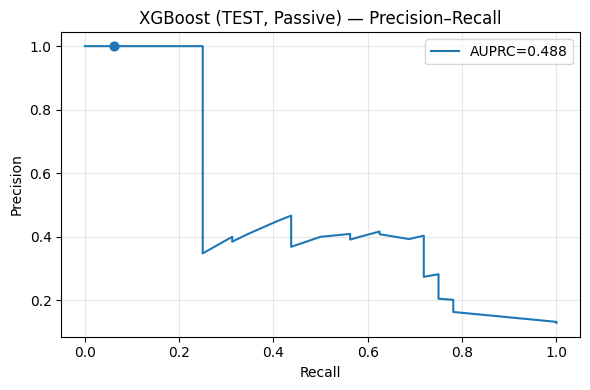

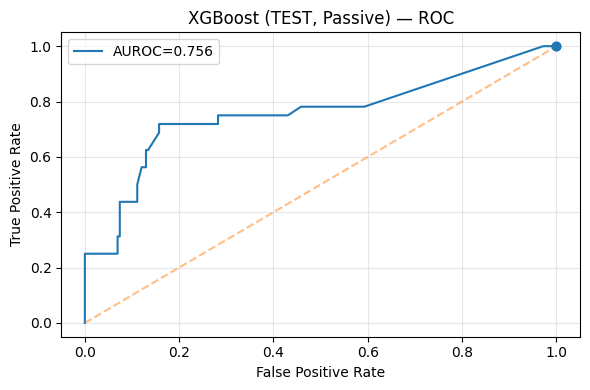

In [30]:
from src.viz import plot_pr_roc

# Passive XGB curves
yt_pass = np.asarray(PASSIVE_RESULTS["yt"].values)
prob_pass = np.asarray(PASSIVE_RESULTS["xgb"]["y_prob_test"])
thr_pass  = float(PASSIVE_RESULTS["xgb"]["thr"])
plot_pr_roc(yt_pass, prob_pass, thr_pass, "XGBoost (TEST, Passive)", SAVE_DIR, "Supp_Passive_XGB")


**Active XGBoost**  
- **PR curve**: More balanced precision-recall trade-off with higher sensitivity.  
- **ROC curve**: Shows strong performance across thresholds.

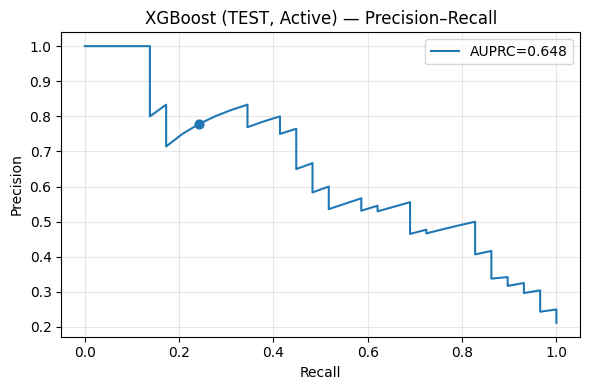

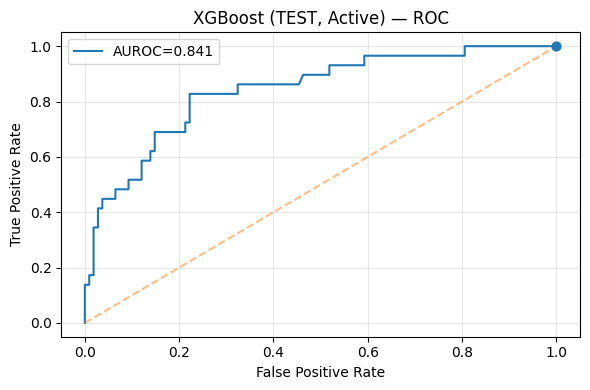

In [31]:
from src.viz import plot_pr_roc
# Active XGB curves
yt_act = np.asarray(ACTIVE_RESULTS["yt"].values)
prob_act = np.asarray(ACTIVE_RESULTS["xgb"]["y_prob_test"])
thr_act  = float(ACTIVE_RESULTS["xgb"]["thr"])
plot_pr_roc(yt_act, prob_act, thr_act, "XGBoost (TEST, Active)", SAVE_DIR, "Supp_Active_XGB")


### **Key takeaways**
- **Active features** (questionnaire data) outperform **passive HR** in terms of both AUROC and AUPRC.
- **XGBoost** consistently outperformed logistic regression in both models.
- **Passive HR** showed moderate discrimination but had low sensitivity, limiting its standalone use for clinical decision-making.

## **<span id="interpretability"></span>Interpretability**

Model interpretability was assessed using **SHAP (SHapley Additive exPlanations)** to understand which features most influenced predictions.

### **SHAP feature importance and summary**

The helper function `shap_topk_plots()` produces two complementary plots for each model:

1. **Bar plot (top-k mean |SHAP| values)** — shows which features contribute most on average.  
2. **Beeswarm plot** — shows how feature values influence the prediction direction (positive vs. negative impact).


**Passive XGBoost (HR)**  
- **Top predictors**: HR variability, circadian HR patterns (morning/evening), and steps.


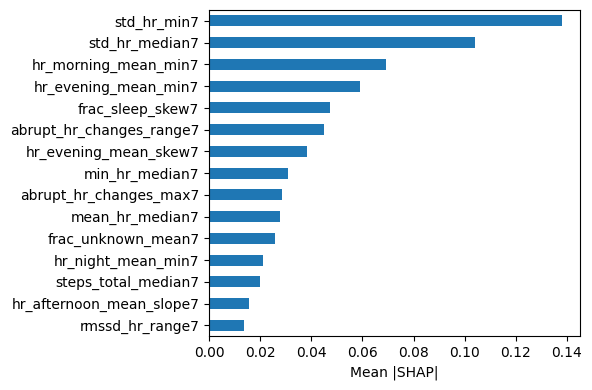

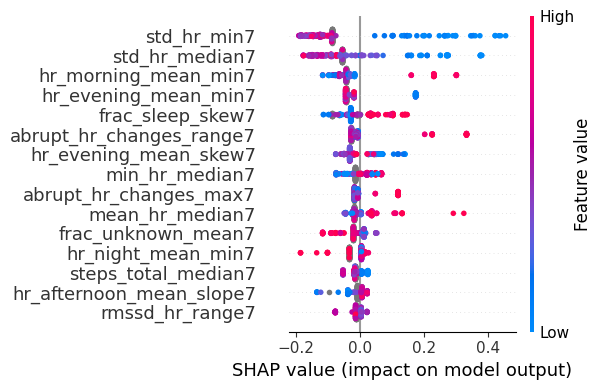

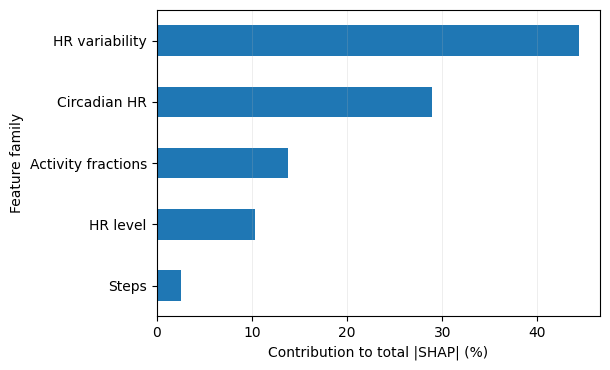

In [32]:
from src.viz import shap_topk_plots, shap_family_plot

# Passive
booster_p = PASSIVE_RESULTS["xgb"]["booster"]
X_test_p  = Xy_passive["test"]["X_scaled"]
shap_topk_plots(booster_p, X_test_p, SAVE_DIR, "Figure5_Passive", topk=15)
shap_family_plot(booster_p, X_test_p, SAVE_DIR, "Supp_SHAP_Family_Passive")

**Active XGBoost (questionnaire)**  
- **Top predictors**: Night-time symptoms, day-time symptoms, and preventer adherence. These features were the most influential in predicting exacerbation risk.


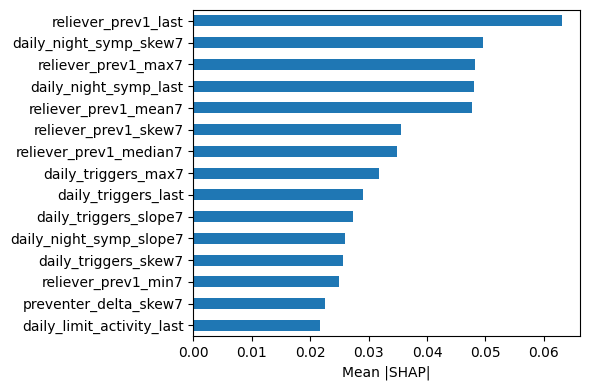

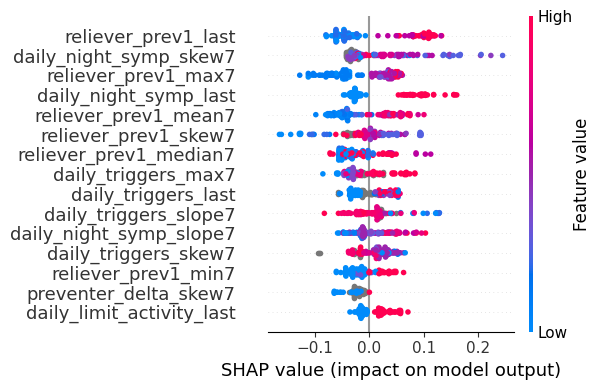

In [33]:
# Active (top features only)
booster_a = ACTIVE_RESULTS["xgb"]["booster"]
X_test_a  = Xy_active["test"]["X_scaled"]
shap_topk_plots(booster_a, X_test_a, SAVE_DIR, "Figure6_Active", topk=15)


## **<span id="sensitivity-analyses"></span>Sensitivity Analyses**

Sensitivity analyses tested how stable model performance was under alternative design and data assumptions.  
Each scenario reused the same end-to-end pipeline but changed one or more configuration parameters.

---

### **Scenarios tested**

| Category | Example parameter variations |
|:--|:--|
| **Outcome definition** | Inhaler-based vs. questionnaire-based labels; ≥2-day vs. consecutive-day definitions |
| **Temporal framing** | Lookback (3–14 days), buffer (1–3 days), horizon (3–5 days) |
| **Scaling / normalization** | Per-user min–max scaling vs. none |
| **Class imbalance** | Random over-/undersampling, SMOTE |
| **Data completeness** | Minimum valid HR days per user (≥50 / ≥75 / ≥100) |

---

### **Passive XGBoost — Sensitivity results**
Changes in predictive performance (AUROC and AUPRC) for the **passive HR-only model** under different parameter settings.





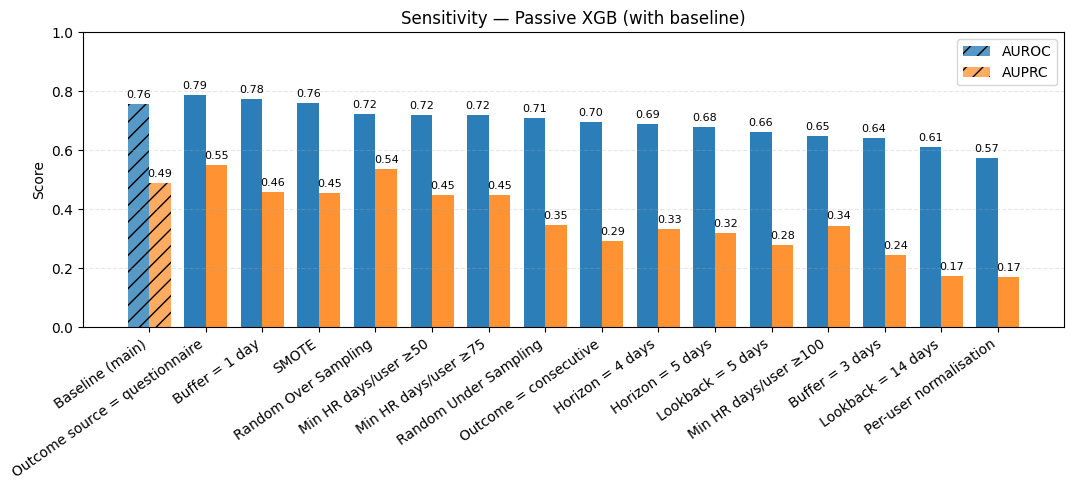

In [34]:
import os, pandas as pd
from src.viz import plot_grouped_bars

# Ensure SAVE_DIR exists
os.makedirs(SAVE_DIR, exist_ok=True)

# --- Passive (Table 8) ---
passive_rows = [
    {"scenario":"Outcome source = questionnaire", "AUROC":0.788, "AUPRC":0.549},
    {"scenario":"Outcome = consecutive",          "AUROC":0.697, "AUPRC":0.293},
    {"scenario":"Per-user normalisation",         "AUROC":0.574, "AUPRC":0.170},
    {"scenario":"Random Over Sampling",           "AUROC":0.722, "AUPRC":0.536},
    {"scenario":"Random Under Sampling",          "AUROC":0.710, "AUPRC":0.346},
    {"scenario":"SMOTE",                          "AUROC":0.759, "AUPRC":0.454},
    {"scenario":"Min HR days/user ≥50",           "AUROC":0.720, "AUPRC":0.448},
    {"scenario":"Min HR days/user ≥75",           "AUROC":0.720, "AUPRC":0.448},
    {"scenario":"Min HR days/user ≥100",          "AUROC":0.647, "AUPRC":0.345},
    {"scenario":"Buffer = 1 day",                 "AUROC":0.775, "AUPRC":0.458},
    {"scenario":"Buffer = 3 days",                "AUROC":0.642, "AUPRC":0.244},
    {"scenario":"Lookback = 5 days",              "AUROC":0.663, "AUPRC":0.279},
    {"scenario":"Lookback = 14 days",             "AUROC":0.611, "AUPRC":0.175},
    {"scenario":"Horizon = 4 days",               "AUROC":0.690, "AUPRC":0.333},
    {"scenario":"Horizon = 5 days",               "AUROC":0.679, "AUPRC":0.319},
]
passive_baseline = {"scenario":"Baseline (main)", "AUROC":0.756, "AUPRC":0.488}
df_passive = pd.DataFrame([passive_baseline] + passive_rows)
df_passive.to_csv(os.path.join(SAVE_DIR, "sensitivity_passive.csv"), index=False)


# Inline plots + silent save to SAVE_DIR (no console printing)
_ = plot_grouped_bars(
    df_passive,
    "Sensitivity — Passive XGB (with baseline)",
    save_path=os.path.join(SAVE_DIR, "Fig_Sens_Passive"),
    show=True
)


**Interpretation:**  
Performance remained relatively stable across most design choices.  
- AUROC values ranged **0.61–0.79**, with the best configuration under **shorter buffer (1 day)**.  
- AUPRC decreased substantially under **per-user normalization** and **longer lookbacks**, suggesting that HR variability relative to personal baseline carries predictive value.  

---

### **Active XGBoost — Sensitivity results**
Equivalent analysis for the **active (questionnaire-based)** model.

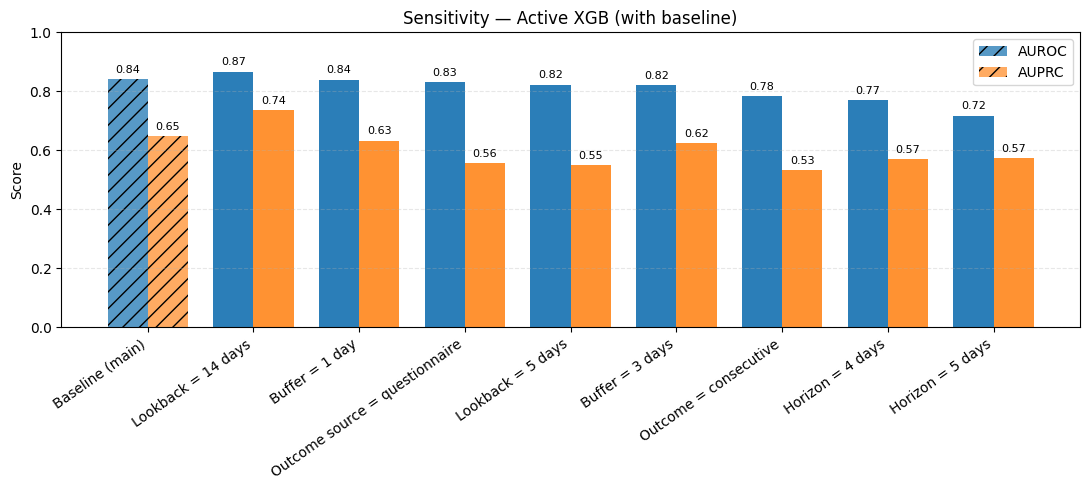

In [35]:
# --- Active (Table 8A) ---
active_rows = [
    {"scenario":"Outcome source = questionnaire", "AUROC":0.831, "AUPRC":0.556},
    {"scenario":"Outcome = consecutive",          "AUROC":0.783, "AUPRC":0.533},
    {"scenario":"Lookback = 5 days",              "AUROC":0.823, "AUPRC":0.550},
    {"scenario":"Lookback = 14 days",             "AUROC":0.867, "AUPRC":0.736},
    {"scenario":"Buffer = 1 day",                 "AUROC":0.840, "AUPRC":0.633},
    {"scenario":"Buffer = 3 days",                "AUROC":0.821, "AUPRC":0.625},
    {"scenario":"Horizon = 4 days",               "AUROC":0.770, "AUPRC":0.570},
    {"scenario":"Horizon = 5 days",               "AUROC":0.718, "AUPRC":0.573},
]
active_baseline = {"scenario":"Baseline (main)", "AUROC":0.841, "AUPRC":0.648}
df_active = pd.DataFrame([active_baseline] + active_rows)
df_active.to_csv(os.path.join(SAVE_DIR, "sensitivity_active.csv"), index=False)

_ = plot_grouped_bars(
    df_active,
    "Sensitivity — Active XGB (with baseline)",
    save_path=os.path.join(SAVE_DIR, "Fig_Sens_Active"),
    show=True
)

**Interpretation:**  
The active model showed greater robustness across all variations.  
- AUROC remained between **0.77–0.87**, and AUPRC between **0.55–0.74**.  
- Shorter buffers or longer lookbacks slightly improved discrimination, while alternative outcome definitions had minor impact.

---

### **Key observations**
- **Active models** consistently outperformed passive ones across all configurations.  
- **Temporal framing** and **data completeness** affected both models more than imbalance or scaling.  
- **Per-user normalization** degraded passive model performance, indicating that absolute HR levels contribute to predictive signal.  
- Overall, results demonstrate **robust performance across moderate design changes**, with **active XGBoost** showing the most consistent generalisation.

## **<span id="limitations"></span>Limitations**

Several factors limit the generalisability of these findings:

- **Outcome capture:** Exacerbations were labelled from reliever inhaler actuations, a clinically recognised marker of worsening asthma. However, incomplete capture may have occurred if participants used non-monitored devices or syncing failed, potentially misclassifying zero-use days. Sensitivity analyses using self-reported reliever use confirmed robustness to this risk.

- **Device missingness:** Weekly smartwatch syncing meant data collection was not fully passive. Gaps in heart-rate coverage required imputation, which may have attenuated short-term variability and reduced sensitivity to acute physiological changes.

- **Cohort size and composition:** The study involved a small, selective sample (n = 22) of adults with severe asthma actively engaged in digital monitoring. This limits robustness and external validity to milder disease, different treatment regimens, and populations with lower digital literacy.

- **Temporal and contextual factors:** Data were collected during the COVID-19 pandemic, which likely reduced exposure to environmental triggers and lowered event frequency—potentially weakening model signal.  

- **Lack of external validation:** Models were trained and evaluated solely within the AAMOS-00 dataset. Broader validation on independent cohorts and devices is required before clinical deployment.

Despite these constraints, the study’s structured temporal framework, leakage-safe evaluation, and extensive sensitivity analyses provide a credible foundation for future research on passive HR-based exacerbation prediction.


In [ ]:
IN_NB = "/content/drive/MyDrive/Colab Notebooks/Dissertation/asthma_exacerbation_wearables.ipynb"
import os; print(os.path.exists(IN_NB), IN_NB)


In [ ]:
%%capture --no-display
!pip -q install nbconvert==7.*
!jupyter nbconvert --to html --no-input --no-prompt \
  --output "index" --output-dir "/content" \
  "{IN_NB}"


In [ ]:
from google.colab import files; files.download("/content/index.html")